# ETF-based portfolio: Rebalance frequency and Tax Loss Harvesting

This is the analysis of returns for an ETF-based portfolio, including a mix of US and foreign stock market and municipal bonds. I will explore different scenarios/frequencies of rebalancing, as well as analyze the benefits of tax loss harvesting during rebalancing.

I'll use a standard set of libraries for data analysis in python - numpy, pandas, matplotlib.pyplot and seaborn for illustrations and some specific functions from pandas time series library.

In [266]:
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import BYearBegin, BMonthBegin, BQuarterBegin

Here I define the portfolio, target distribution, dates for the analysis and investment amount.

In [267]:
# Define target distributions
tickers = ['VTI','VEA','VWO','VIG','XLE','MUB']
compos = [.35,.17,.14,.06,.05,.23]
# compos = [1.0,0,0,0,0,0]
syms = symbols(tickers)

# Define dates for the analysis - the endDate is when we are going to calculate the final return of portfolio
startDate = '2008-01-01'
endDate = '2016-05-01'

# Define amount to be invested
investment = 100000

Converting the target distribution to dataframe and defining column names for the future portfolio dataframe.

In [268]:
# Define column names for portfolio dataframe
columns = ['dates','cashAmount','stockValue','totValue','tradeProfit','tradeLoss']

# Create a target distribution dataframe
dfTgt = pd.DataFrame({'symbol':syms,'dist':compos,'ticker':tickers}).set_index('ticker')

Download prices for specified assets and for the market benchmark.

In [293]:
dfPcg = get_pricing(tickers,
            fields='close_price', 
            start_date=startDate,
            end_date=endDate)

SPY = get_pricing(symbols('SPY'),
            fields='close_price', 
            start_date=startDate,
            end_date=endDate)

### Auxiliary Functions

Let's define the auxiliary shared functions. 

First since the two dataframes with pricing information contain only stock trading dates I will create a function to simplify evaluating different frequencies of rebalancing later on. It will find all valid trading dates (for which the prices are defined) for a desired range and with desired frequency (annual, quarterly, monthly and may be extended to weekly). The resulting list of dates will also include the end date at which the performance of the portfolio will be calculated.

In [270]:
# function to define the trading dates for the range of years with desired frequency
def defineDates(rng,freq):
    dates = []
    short = dfPcg[rng[0]:rng[1]]
    endDate = short.iloc[short.shape[0]-1].name
    curDate = short.iloc[0].name
    dates.append(curDate)
    
    while curDate < endDate:
        if freq == 'Y':
            curDate = curDate+BYearBegin()
            if curDate > endDate:
                dates.append(endDate)
                return dates
            else:
                curDate = short[curDate:].iloc[0].name
                dates.append(curDate)
        if freq == 'Q':
            curDate = curDate+BQuarterBegin()
            if curDate > endDate:
                dates.append(endDate)
                return dates
            else:
                curDate = short[curDate:].iloc[0].name
                dates.append(curDate)
        if freq == 'M':
            curDate = curDate+BMonthBegin()
            if curDate > endDate:
                dates.append(endDate)
                return dates
            else:
                curDate = short[curDate:].iloc[0].name
                dates.append(curDate)

    dates.append(endDate)
    return dates

In [271]:
# Example of the output
dates = defineDates(['2015-02',endDate],'M')
dates

[Timestamp('2015-02-02 00:00:00+0000', tz='UTC'),
 Timestamp('2015-03-02 00:00:00+0000', tz='UTC'),
 Timestamp('2015-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-05-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-06-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-07-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-08-03 00:00:00+0000', tz='UTC'),
 Timestamp('2015-09-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-10-01 00:00:00+0000', tz='UTC'),
 Timestamp('2015-11-02 00:00:00+0000', tz='UTC'),
 Timestamp('2015-12-01 00:00:00+0000', tz='UTC'),
 Timestamp('2016-01-04 00:00:00+0000', tz='UTC'),
 Timestamp('2016-02-01 00:00:00+0000', tz='UTC'),
 Timestamp('2016-03-01 00:00:00+0000', tz='UTC'),
 Timestamp('2016-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2016-04-29 00:00:00+0000', tz='UTC')]

The function to calculate the performance of the portfolio, returing the dictionary with return, final portfolio value, final distribution of assets and benchmark values for SPY index.

In [272]:
def calcPortfolioPerformance(df):
    result = dict()
    
    result['investment'] = investment
    result['cashAmount'] = df.ix[-1:].cashAmount.values[0]
    result['totValue'] = df.ix[-1:].totValue.values[0]
    result['return'] = (result['totValue'] - result['investment'])/result['investment']
    result['market'] = (SPY.ix[-1:].values[0]/SPY.values[0]-1)
    
    # Calculate final distribution
    assets = np.array(tickers)
    endDist = (dfPtf.ix[-1:,tickers].values*dfPcg.ix[-1:].values)/result['totValue']
    tgtDist = dfTgt.dist.values
    result['dist'] = pd.DataFrame(data=np.vstack((assets,endDist,tgtDist)).T,columns=['ticker','endDist','tgtDist'])
    

    print "Total Invested:\t\t ${:10.1f}".format(result['investment'])
    print "Portfolio Value:\t ${:10.1f}".format(result['totValue'])
    print "Remaining cash:\t\t ${:10.1f}".format(result['cashAmount'])
    print "-------------------------"
    print "Portfolio ROI:\t {:5.1f}%".format(result['return']*100)
    print "Market ROI:\t {:5.1f}%".format(result['market']*100)

    return result


The function to generate a standard set of graphics for analysis and comparison.

In [296]:
def plotPortfolioPerformance(ptf,results):
    width = 0.25
    pos = list(range(len(tickers)))
    dist = results['dist']
    
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,8))

    #First subplot
    ax1.bar(pos,
            dist.tgtDist, 
            width, 
            alpha=0.5, 
            color='#EE3224', 
            label='Target') 
    ax1.bar([p + width for p in pos], 
            dist.endDist,
            width, 
            alpha=0.5, 
            color='#F78F1E', 
            label='End')
    ax1.set_ylabel('Ratio in Total Value')
    ax1.set_title('Portfolio composition')
    ax1.set_xticks([p + 1 * width for p in pos])
    ax1.set_xticklabels(tickers)
    ax1.set_xlim(min(pos)-width, max(pos)+width*4)
    ax1.legend(loc='upper right')
    ax1.grid(False)
    
    # Second subplot
    ax2.plot(ptf.index,
             (ptf.totValue-results['investment'])/results['investment']*100,
             color='#F78F1E',
             label='Portfolio')
    ax2.plot(ptf.index,
             (SPY.ix[ptf.index].values/SPY.values[0]-1)*100,
             color='#EE3224',
             label='Market')
    ax2.axhline(color='#43a2ca',linewidth = 1.0)
    ax2.grid(False)
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Return on Investment, %')
    
    plt.show()

### Baseline

As a baseline case let's consider the portfolio created at the start date following the initial distribution. We neglect the interest rate on remaining cash. At the end we calculate the return on investment.

There is no rebalancing so the distribution of the stock and remaining cash will not change. I just need to calculate the portvolio value at defined dates, which may be done using pandas df.apply() functionality.

Total Invested:		 $  100000.0
Portfolio Value:	 $  112317.4
Remaining cash:		 $     300.8
-------------------------
Portfolio ROI:	  12.3%
Market ROI:	  42.7%


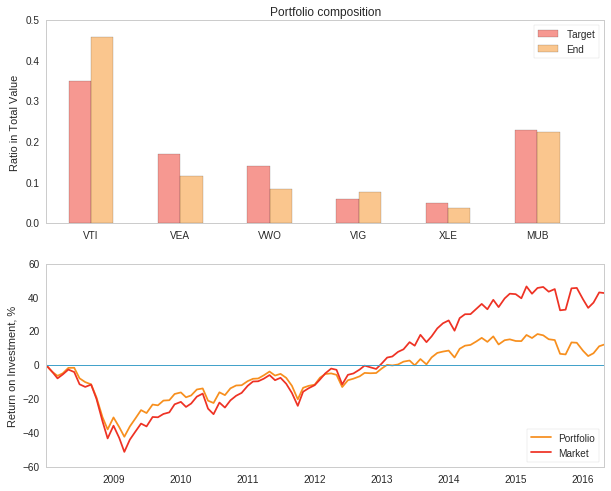

In [297]:
# Defining dates to track the performance
dates = defineDates([startDate,endDate],'M')

# Initiate portfolio dataframe
dfPtf = pd.DataFrame(np.zeros((len(dates),len(columns)+len(tickers))))
dfPtf.columns = columns+tickers
dfPtf = dfPtf.set_index('dates')
dfPtf.index = dates

# Initiate the portfolio - no rebalancing, so some numbers won't change
amounts = np.floor(investment*dfTgt.dist.values/dfPcg.ix[dates[0]].values)
dfPtf[tickers] = amounts
dfPtf['cashAmount'] = investment - np.sum(amounts*dfPcg.ix[dates[0]].values)

# Calculate the changing values
dfPtf['stockValue'] = dfPtf.apply(lambda row: np.sum(row[tickers].values*dfPcg.ix[row.name].values) , axis=1)
dfPtf['totValue'] = dfPtf['stockValue']+dfPtf['cashAmount']
   
# # Calling the calculation cycle and showing results
returns = calcPortfolioPerformance(dfPtf)
plotPortfolioPerformance(dfPtf,returns)

As expected the ROI of the mixed portfolio is lower than the market due to a mix of bonds. The final distribution of the portfolio is also quite different from the target.

### Scenario 1: Annual Rebalancing

The first scenario is annual rebalancing. To simplify further analysis again let's first create the function which will adjust the portfolio at a defined trade dates.

The important thing to mention here is that during rebalance we are selling the assets which gained value to buy assets which lost value. As we sell we realize capital gains, which are taxable. There are different techniques to optimize it which are outside of the scope of the analysis, [one example](http://www.marketwatch.com/story/how-to-cut-your-taxes-using-etfs-2015-05-07) is to use dividends to re-invest and then sell those assets which you bought lately and which haven't appreciated much yet. 

But for now this function will calculate the capital gains generated assuming that we held assets since the launch of the portfolio, which is likely the worst-case scenario. And I will apply the tax and include it into the overall ROI calculation later. 

In [275]:
# Input - portfolio dataframe and trade/rebalance dates
def calcRebalance(df, dates):
    
    for i,date in enumerate(dates):

        # Take old stock and cash amounts from the previous rebalancing period
        # otherwise - redo calculation for the start date
        if i > 0:
            oldAmounts = df.ix[i-1,tickers]
            oldCash = df.ix[i-1,'cashAmount']
        else:
            oldAmounts = df.ix[i,tickers]
            oldCash = df.ix[i,'cashAmount']
        
        # Current prices
        curPrices = dfPcg.ix[date].values
            
        # Calculate total value before rebalance
        oldStockValue = np.sum(oldAmounts*curPrices) # stock value at current prices
        totalValue = oldStockValue+oldCash # total value of the portfolio
        
        # These are the new amounts to preserve the target distribution within the current total value
        newAmounts = np.floor(totalValue*dfTgt.dist.values/curPrices)
        
        # Calculate capital gains
        deltaAmount = oldAmounts-newAmounts
        deltaValue = deltaAmount*(curPrices-dfPcg.ix[0].values)

        # Rebalancing - generates profit by selling assets
        tradeProfit = np.sum(deltaValue[deltaValue > 0].values)
        
        # New portfolio
        newStockValue = np.sum(newAmounts*curPrices)
        newCash = totalValue - newStockValue
        
        # Assign current values
        df.ix[i,tickers] = newAmounts
        df.ix[i,'stockValue'] = newStockValue
        df.ix[i,'totValue'] = totalValue
        df.ix[i,'tradeProfit'] = tradeProfit
        df.ix[i,'cashAmount'] = newCash
    return df

Now let's define dates and initialize the dataframe by calculating initial amounts and cash.

Total Invested:		 $  100000.0
Portfolio Value:	 $  114686.8
Remaining cash:		 $     260.8
-------------------------
Portfolio ROI:	  14.7%
Market ROI:	  42.7%


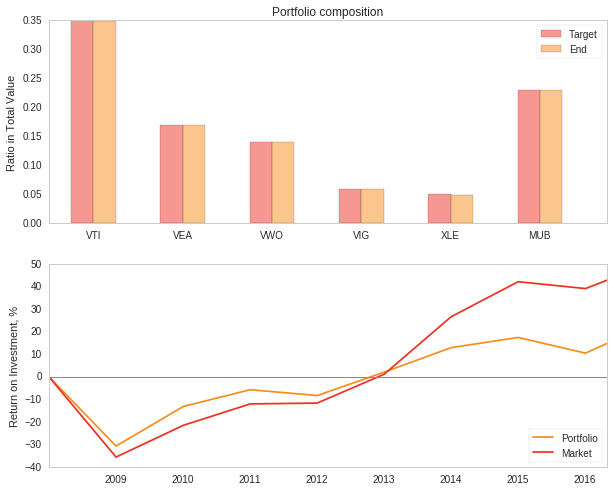

In [298]:
# Defining dates - annual rebalancing
dates = defineDates([startDate,endDate],'Y')

# Initiate portfolio dataframe
dfPtf = pd.DataFrame(np.zeros((len(dates),len(columns)+len(tickers))))
dfPtf.columns = columns+tickers
dfPtf = dfPtf.set_index('dates')
dfPtf.index = dates

# Add the investment at start date - need number of stocks and remaining cash only
amounts = np.floor(investment*dfTgt.dist.values/dfPcg.ix[dates[0]].values)
dfPtf.ix[0,tickers] = amounts
dfPtf.ix[0,'cashAmount'] = investment - np.sum(amounts*dfPcg.ix[dates[0]].values)

# Calculation cycle
dfPtf = calcRebalance(dfPtf,dates)
   
# Calling the calculation cycle and showing results
returns = calcPortfolioPerformance(dfPtf)
plotPortfolioPerformance(dfPtf,returns)

Let's look at the capital gains now.

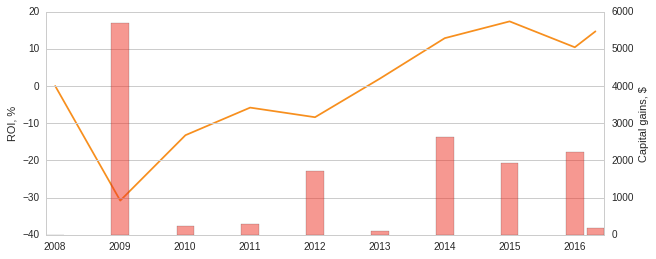

In [302]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(dfPtf.index,(dfPtf.totValue-returns['investment'])/returns['investment']*100,color='#F78F1E',label='Portfolio')
ax1.axhline(color='#43a2ca',linewidth = 1.0)
ax1.grid(False)
ax1.set_ylabel('ROI, %')

ax2 = ax1.twinx()
ax2.bar(dfPtf.index,dfPtf.tradeProfit,width=100,alpha=0.5,color='#EE3224',align="center")
ax2.set_ylabel('Capital gains, $')
plt.show()

Capital gains are quite considerable, especially in the first period when market dropped and significant rebalance was required. There is definitely a great potential for tax loss harvesting here to offset some of it, but first let's see the total tax impact. For this we'll assume the 20% tax rate on long-term income, corresponding to the highest tax bracket in US.

Let's update the performance calculation function to include it into ROI calculation.

In [319]:
def calcPortfolioPerformanceWithTax(df):
    result = dict()
    
    result['investment'] = investment
    result['cashAmount'] = df.ix[-1:].cashAmount.values[0]
    result['totValue'] = df.ix[-1:].totValue.values[0]
    result['totalCapitalGain'] = df.tradeProfit.sum()
    result['return'] = (result['totValue']-result['investment'])/result['investment']
    result['returnTax'] = (result['totValue']-result['investment']-0.2*result['totalCapitalGain'])/result['investment']
    result['market'] = (SPY.ix[-1:].values[0]/SPY.values[0]-1)
    
    # Calculate final distribution
    assets = np.array(tickers)
    endDist = (dfPtf.ix[-1:,tickers].values*dfPcg.ix[-1:].values)/result['totValue']
    tgtDist = dfTgt.dist.values
    result['dist'] = pd.DataFrame(data=np.vstack((assets,endDist,tgtDist)).T,columns=['ticker','endDist','tgtDist'])
    

    print "Total Invested:\t\t ${:10.1f}".format(result['investment'])
    print "Portfolio Value:\t ${:10.1f}".format(result['totValue'])
    print "Remaining cash:\t\t ${:10.1f}".format(result['cashAmount'])
    print "Capital tax:\t\t ${:10.1f}".format(result['totalCapitalGain']*0.2)
    print "-------------------------"
    print "Portfolio ROI:\t {:5.1f}%".format(result['return']*100)
    print "ROI w/Tax:\t {:5.1f}%".format(result['returnTax']*100)
    print "Market ROI:\t {:5.1f}%".format(result['market']*100)

    return result

In [320]:
annualPerformance=calcPortfolioPerformanceWithTax(dfPtf)

Total Invested:		 $  100000.0
Portfolio Value:	 $  114686.8
Remaining cash:		 $     260.8
Capital tax:		 $    3001.8
-------------------------
Portfolio ROI:	  14.7%
ROI w/Tax:	  11.7%
Market ROI:	  42.7%


This is the interesting result as we see that the new ROI with capital gain tax due to rebalance actually less than for the portfolio without rebalance. There are a lot of assumptions here, of course and some optimizations are possible, but still I believe it is quite logical.

### Scenario 2: Monthly Rebalancing

Let's explore the monthly rebalancing just to see the trend and if there is any improvement vs annual. The function is ready, so running it with a new frequency is straightforward and requires almost no changes other than updating dates.

Total Invested:		 $  100000.0
Portfolio Value:	 $  113202.1
Remaining cash:		 $     218.6
-------------------------
Portfolio ROI:	  13.2%
Market ROI:	  42.7%


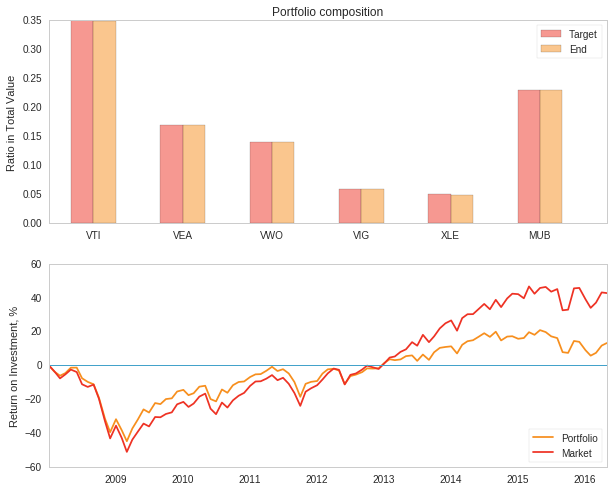

In [323]:
# Defining dates - monthly rebalancing
dates = defineDates([startDate,endDate],'M')

# Initiate portfolio dataframe
dfPtf = pd.DataFrame(np.zeros((len(dates),len(columns)+len(tickers))))
dfPtf.columns = columns+tickers
dfPtf = dfPtf.set_index('dates')
dfPtf.index = dates

# Add the investment at start date - need number of stocks and remaining cash only
amounts = np.floor(investment*dfTgt.dist.values/dfPcg.ix[dates[0]].values)
dfPtf.ix[0,tickers] = amounts
dfPtf.ix[0,'cashAmount'] = investment - np.sum(amounts*dfPcg.ix[dates[0]].values)

# Calculation cycle
dfPtf = calcRebalance(dfPtf,dates)
   
# Calling the calculation cycle and showing results
returns = calcPortfolioPerformance(dfPtf)
plotPortfolioPerformance(dfPtf,returns)

Well, another somewhat counterintuitive result - the monthly rebalancing without tax considerations provided lower ROI than annual case. Of course it may be the result of the specific period considered, however increasing the frequency of rebalancing already failed to be universal. 

Let's see the final performance with tax.

In [324]:
monthlyPerformance=calcPortfolioPerformanceWithTax(dfPtf)

Total Invested:		 $  100000.0
Portfolio Value:	 $  113202.1
Remaining cash:		 $     218.6
Capital tax:		 $    5590.0
-------------------------
Portfolio ROI:	  13.2%
ROI w/Tax:	   7.6%
Market ROI:	  42.7%


Due to more frequent rebalancing the total tax is higher and as a result the ROI with tax is even lower - only 7.6% over 8 years considered.

### Scenario 3: Quarterly Rebalancing

Initially I was going to skip this case, however now it is interesting to see the trend and whether there is any sweet spot. We know that rebalancing makes sense since annual rebalancing had better performance than baseline.

Total Invested:		 $  100000.0
Portfolio Value:	 $  115203.6
Remaining cash:		 $     125.9
Capital tax:		 $    4338.8
-------------------------
Portfolio ROI:	  15.2%
ROI w/Tax:	  10.9%
Market ROI:	  42.7%


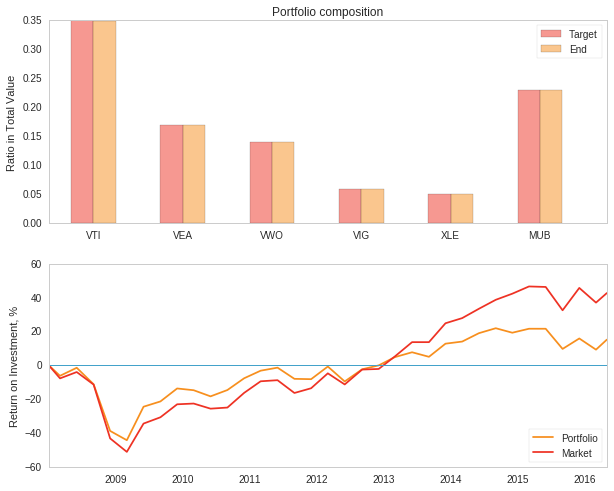

In [326]:
# Defining dates - monthly rebalancing
dates = defineDates([startDate,endDate],'Q')

# Initiate portfolio dataframe
dfPtf = pd.DataFrame(np.zeros((len(dates),len(columns)+len(tickers))))
dfPtf.columns = columns+tickers
dfPtf = dfPtf.set_index('dates')
dfPtf.index = dates

# Add the investment at start date - need number of stocks and remaining cash only
amounts = np.floor(investment*dfTgt.dist.values/dfPcg.ix[dates[0]].values)
dfPtf.ix[0,tickers] = amounts
dfPtf.ix[0,'cashAmount'] = investment - np.sum(amounts*dfPcg.ix[dates[0]].values)

# Calculation cycle
dfPtf = calcRebalance(dfPtf,dates)
   
# Calling the calculation cycle and showing results
returns = calcPortfolioPerformanceWithTax(dfPtf)
plotPortfolioPerformance(dfPtf,returns)

And quarterly rebalancing beats the annual one without tax consideration, however due to a higher tax has a lower final ROI.

### Intermediate Conclusion

Rebalancing provided the improvement over the baseline case. The optimal frequency for the considered portfolio and range appeared to be quarterly. However the realized capital gains offset all gains of rebalancing and the final ROI with capital tax is lower than for the non-rebalanced baseline case.

Now as I saw the impact of the capital gain tax on ROI it makes sense to consider different tax optimization techniques, and in particular the tax [loss harvesting](https://www.betterment.com/tax-loss-harvesting/).

### Rebalancing with Tax Loss Harvesting

I will not consider the technicalities of tax loss harvesting, such as selecting a similar correlated ETF, not re-buying the original ETF for 31 days, etc, although these have to be implemented in the trading algorithm. For the purpose of the analysis I will ignore these and will only see if I can generate enough opportunities for tax loss harvesting every year.

As usual let's start by writing a new portfolio propagation function.

In [327]:
# Input - portfolio dataframe and trade/rebalance dates
def calcRebalanceTaxLoss(df, dates):
    
    for i,date in enumerate(dates):

        # Take old stock and cash amounts from the previous rebalancing period
        # otherwise - redo calculation for the start date
        if i > 0:
            oldAmounts = df.ix[i-1,tickers]
            oldCash = df.ix[i-1,'cashAmount']
        else:
            oldAmounts = df.ix[i,tickers]
            oldCash = df.ix[i,'cashAmount']
        
        # Current prices
        curPrices = dfPcg.ix[date].values
            
        # Calculate total value before rebalance
        oldStockValue = np.sum(oldAmounts*curPrices) # stock value at current prices
        totalValue = oldStockValue+oldCash # total value of the portfolio
        
        # These are the new amounts to preserve the target distribution within the current total value
        newAmounts = np.floor(totalValue*dfTgt.dist.values/curPrices)
        
        # Calculate capital gains
        deltaAmount = oldAmounts-newAmounts
        deltaValue = deltaAmount*(curPrices-dfPcg.ix[0].values)

        # Rebalancing - generates profit by selling assets
        tradeProfit = np.sum(deltaValue[deltaValue > 0].values)
        
        # New portfolio
        newStockValue = np.sum(newAmounts*curPrices)
        newCash = totalValue - newStockValue
        
        # Assign current values
        df.ix[i,tickers] = newAmounts
        df.ix[i,'stockValue'] = newStockValue
        df.ix[i,'totValue'] = totalValue
        df.ix[i,'tradeProfit'] = tradeProfit
        df.ix[i,'cashAmount'] = newCash
    return df